In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
import pandas as pd

In [30]:
df = pd.read_json('/content/drive/MyDrive/ML_Data/term_labeled_texts_val.json')
df.head()

,tokenized_text,token_labels,new_terms
0,"[АНАЛИЗ, ЛЕКСИКО‐СЕМАНТИЧЕСКИХ, ОСОБЕННОСТЕЙ, ...","[O, B, E, B, E, O, O, O, O, O, O, O, O, O, O, ...","[ЛЕКСИКО‐СЕМАНТИЧЕСКИХ ОСОБЕННОСТЕЙ, РЕГИОНАЛЬ..."
1,"[ИСПОЛЬЗОВАНИЕ, МЕТОДА, УСЛОВНЫХ, СЛУЧАЙНЫХ, П...","[O, B, I, I, E, O, O, O, O, B, E, O, O, O, B, ...","[МЕТОДА УСЛОВНЫХ СЛУЧАЙНЫХ ПОЛЕЙ, РУССКОМ ЯЗЫК..."
2,"[МНОГОЗНАЧНОСТЬ, КАК, ПРИКЛАДНАЯ, ПРОБЛЕМА, :,...","[S, O, O, O, O, B, I, I, E, O, B, I, I, E, O, ...","[МНОГОЗНАЧНОСТЬ, ЛЕКСИКО-СЕМАНТИЧЕСКАЯ РАЗМЕТК..."
3,"[ОПИСАНИЕ, ФРАГМЕНТОВ, С, ПРЯМОЙ, РЕЧЬЮ, В, ПО...","[O, O, O, B, E, O, B, E, B, E, O, O, O, O, O, ...","[ПРЯМОЙ РЕЧЬЮ, ПОВЕСТВОВАТЕЛЬНЫХ КНИГАХ, ЕВРЕЙ..."
4,"[ГЕНЕРАЦИЯ, ШАБЛОНОВ, ОЦЕНОЧНЫХ, ВЫРАЖЕНИЙ, НА...","[S, S, B, E, O, O, B, E, O, O, O, O, O, B, E, ...","[ГЕНЕРАЦИЯ, ШАБЛОНОВ, ОЦЕНОЧНЫХ ВЫРАЖЕНИЙ, НЕР..."


In [31]:
from transformers import TokenClassificationPipeline, AutoTokenizer, AutoModelForTokenClassification

In [32]:
tokenizer_term = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [33]:
def postprocess_output(output):

  id2tag = {0: 'O', 1: 'S', 2: 'B', 3: 'I', 4: 'E'}

  string = ''
  tags = []
  last_token_end = 0

  for token in output:
    # сначала обработаем pos-тег
    if '_' in token['entity']:
      pos = id2tag[int(token['entity'].split('_')[1])]
    else:
      pos = token['entity']

    if token['word'][0] != '#':
      # если токен - или начало слова, или полное слово
      if last_token_end != token['start']:
        string += ' '

      string += token['word']
      tags.append(pos)

    else:
      # если токен - середина слова или конец
      string += token['word'].replace('#', '')

    last_token_end = token['end']

  return list(zip(string.split(), tags))

In [34]:
checkpoint = '/content/drive/MyDrive/ML/Project_Terminology_2/Model_Term_Distilbert_max' # модель училась 50 эпох

In [35]:
model_term = AutoModelForTokenClassification.from_pretrained(checkpoint)

In [36]:
termbert = TokenClassificationPipeline(model=model_term, tokenizer=tokenizer_term, task="pos")

In [37]:
postprocess_output(termbert('В данной статье описываются основные принципы работы синтаксического парсера русского языка LPaRus , разработанного на основе лингвистических технологий компании Megaputer Intelligence .'))

[('в', 'O'),
 ('даннои', 'O'),
 ('статье', 'O'),
 ('описываются', 'O'),
 ('основные', 'O'),
 ('принципы', 'O'),
 ('работы', 'O'),
 ('синтаксического', 'B'),
 ('парсера', 'E'),
 ('русского', 'B'),
 ('языка', 'E'),
 ('lparus', 'S'),
 (',', 'O'),
 ('разработанного', 'O'),
 ('на', 'O'),
 ('основе', 'O'),
 ('лингвистических', 'B'),
 ('технологии', 'E'),
 ('компании', 'O'),
 ('megaputer', 'S'),
 ('intelligence', 'E'),
 ('.', 'O')]

In [38]:
def get_predicted_labels(x):

  labels_pred = []

  text = ' '.join(x['tokenized_text'])
  output = postprocess_output(termbert(text))
  tokens = [i[1] for i in output]
  for i in tokens:
    labels_pred.append(i)

  return labels_pred


In [39]:
df['pred_labels'] = df.apply(get_predicted_labels, axis=1)

In [40]:
df.head()

,tokenized_text,token_labels,new_terms,pred_labels
0,"[АНАЛИЗ, ЛЕКСИКО‐СЕМАНТИЧЕСКИХ, ОСОБЕННОСТЕЙ, ...","[O, B, E, B, E, O, O, O, O, O, O, O, O, O, O, ...","[ЛЕКСИКО‐СЕМАНТИЧЕСКИХ ОСОБЕННОСТЕЙ, РЕГИОНАЛЬ...","[O, S, O, B, I, I, E, O, O, O, O, B, I, E, O, ..."
1,"[ИСПОЛЬЗОВАНИЕ, МЕТОДА, УСЛОВНЫХ, СЛУЧАЙНЫХ, П...","[O, B, I, I, E, O, O, O, O, B, E, O, O, O, B, ...","[МЕТОДА УСЛОВНЫХ СЛУЧАЙНЫХ ПОЛЕЙ, РУССКОМ ЯЗЫК...","[O, O, B, I, E, O, B, E, O, B, E, O, O, O, O, ..."
2,"[МНОГОЗНАЧНОСТЬ, КАК, ПРИКЛАДНАЯ, ПРОБЛЕМА, :,...","[S, O, O, O, O, B, I, I, E, O, B, I, I, E, O, ...","[МНОГОЗНАЧНОСТЬ, ЛЕКСИКО-СЕМАНТИЧЕСКАЯ РАЗМЕТК...","[S, O, B, E, O, B, I, I, E, O, B, I, I, E, O, ..."
3,"[ОПИСАНИЕ, ФРАГМЕНТОВ, С, ПРЯМОЙ, РЕЧЬЮ, В, ПО...","[O, O, O, B, E, O, B, E, B, E, O, O, O, O, O, ...","[ПРЯМОЙ РЕЧЬЮ, ПОВЕСТВОВАТЕЛЬНЫХ КНИГАХ, ЕВРЕЙ...","[O, O, O, O, S, O, B, I, I, E, O, O, O, O, O, ..."
4,"[ГЕНЕРАЦИЯ, ШАБЛОНОВ, ОЦЕНОЧНЫХ, ВЫРАЖЕНИЙ, НА...","[S, S, B, E, O, O, B, E, O, O, O, O, O, B, E, ...","[ГЕНЕРАЦИЯ, ШАБЛОНОВ, ОЦЕНОЧНЫХ ВЫРАЖЕНИЙ, НЕР...","[S, B, I, E, O, O, B, E, O, O, O, O, O, O, O, ..."


In [41]:
def len_check(x):

  result = (len(x['token_labels']), len(x['pred_labels']))
  return result

In [42]:
df['len_check'] = df.apply(len_check, axis=1)

In [43]:
df

,tokenized_text,token_labels,new_terms,pred_labels,len_check
0,"[АНАЛИЗ, ЛЕКСИКО‐СЕМАНТИЧЕСКИХ, ОСОБЕННОСТЕЙ, ...","[O, B, E, B, E, O, O, O, O, O, O, O, O, O, O, ...","[ЛЕКСИКО‐СЕМАНТИЧЕСКИХ ОСОБЕННОСТЕЙ, РЕГИОНАЛЬ...","[O, S, O, B, I, I, E, O, O, O, O, B, I, E, O, ...","(192, 83)"
1,"[ИСПОЛЬЗОВАНИЕ, МЕТОДА, УСЛОВНЫХ, СЛУЧАЙНЫХ, П...","[O, B, I, I, E, O, O, O, O, B, E, O, O, O, B, ...","[МЕТОДА УСЛОВНЫХ СЛУЧАЙНЫХ ПОЛЕЙ, РУССКОМ ЯЗЫК...","[O, O, B, I, E, O, B, E, O, B, E, O, O, O, O, ...","(64, 64)"
2,"[МНОГОЗНАЧНОСТЬ, КАК, ПРИКЛАДНАЯ, ПРОБЛЕМА, :,...","[S, O, O, O, O, B, I, I, E, O, B, I, I, E, O, ...","[МНОГОЗНАЧНОСТЬ, ЛЕКСИКО-СЕМАНТИЧЕСКАЯ РАЗМЕТК...","[S, O, B, E, O, B, I, I, E, O, B, I, I, E, O, ...","(77, 77)"
3,"[ОПИСАНИЕ, ФРАГМЕНТОВ, С, ПРЯМОЙ, РЕЧЬЮ, В, ПО...","[O, O, O, B, E, O, B, E, B, E, O, O, O, O, O, ...","[ПРЯМОЙ РЕЧЬЮ, ПОВЕСТВОВАТЕЛЬНЫХ КНИГАХ, ЕВРЕЙ...","[O, O, O, O, S, O, B, I, I, E, O, O, O, O, O, ...","(95, 87)"
4,"[ГЕНЕРАЦИЯ, ШАБЛОНОВ, ОЦЕНОЧНЫХ, ВЫРАЖЕНИЙ, НА...","[S, S, B, E, O, O, B, E, O, O, O, O, O, B, E, ...","[ГЕНЕРАЦИЯ, ШАБЛОНОВ, ОЦЕНОЧНЫХ ВЫРАЖЕНИЙ, НЕР...","[S, B, I, E, O, O, B, E, O, O, O, O, O, O, O, ...","(152, 74)"
5,"[ФРАЗОВАЯ, АКЦЕНТУАЦИЯ, В, СЛОЖНЫХ, ПРЕДЛОЖЕНИ...","[B, E, O, B, E, O, B, E, O, B, E, O, O, O, B, ...","[ФРАЗОВАЯ АКЦЕНТУАЦИЯ, СЛОЖНЫХ ПРЕДЛОЖЕНИЯХ, П...","[B, E, O, B, E, O, B, E, O, B, E, O, O, O, B, ...","(72, 72)"
6,"[Лексико, -, грамматические, базы, данных, и, ...","[B, I, I, I, E, O, O, O, O, B, I, E, O, O, S, ...","[Лексико-грамматические базы данных, диалектны...","[B, I, I, I, E, O, O, O, O, B, I, E, O, O, O, ...","(52, 52)"
7,"[ЛЕКСИКАЛИЗОВАННАЯ, ПРОСОДИЯ, И, ПОЛИСЕМИЯ, ДИ...","[B, E, O, S, B, E, O, O, O, B, I, E, O, O, B, ...","[ЛЕКСИКАЛИЗОВАННАЯ ПРОСОДИЯ, ПОЛИСЕМИЯ, ДИСКУР...","[B, E, O, S, B, E, O, O, O, O, O, S, O, O, B, ...","(198, 88)"
8,"[ИНТОНАЦИЯ, РЕЧЕВЫХ, ДЕЙСТВИЙ, ., МНОГОЗНАЧНОС...","[S, B, E, O, S, O, B, E, O, O, O, B, I, I, I, ...","[ИНТОНАЦИЯ, РЕЧЕВЫХ ДЕЙСТВИЙ, МНОГОЗНАЧНОСТЬ, ...","[S, B, E, O, O, O, O, S, O, O, O, O, O, O, O, ...","(50, 50)"
9,"[Особенности, подготовки, терминов, для, русск...","[O, O, S, O, O, O, O, S, O, B, E, O, O, O, O, ...","[терминов, тезауруса, компьютерной лингвистике...","[O, B, S, O, O, O, O, S, O, B, E, O, O, O, O, ...","(61, 61)"


In [44]:
labels_pred = []

for i in range(50):
  for n in df['pred_labels'][i]:
    labels_pred.append(n)

In [45]:
len(labels_pred)

3536

In [46]:
labels_true = []

for i in range(50):
  tokens = df['token_labels'][i][:len(df['pred_labels'][i])]
  for i in tokens:
    labels_true.append(i)

In [47]:
len(labels_true)

3536

In [48]:
import numpy

In [49]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
y_true = numpy.array(labels_true)
y_pred = numpy.array(labels_pred)

In [50]:
y_true.shape

(3536,)

In [51]:
y_pred.shape

(3536,)

In [52]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           B       0.65      0.67      0.66       375
           E       0.68      0.72      0.70       371
           I       0.60      0.49      0.54       152
           O       0.90      0.89      0.89      2384
           S       0.56      0.61      0.58       254

    accuracy                           0.81      3536
   macro avg       0.68      0.67      0.67      3536
weighted avg       0.81      0.81      0.81      3536



In [53]:
import matplotlib.pyplot as plt

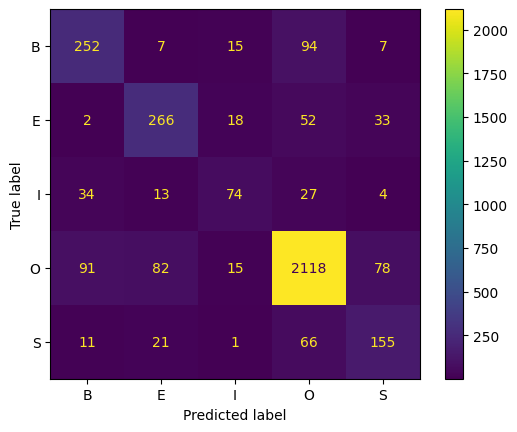

In [54]:
ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
plt.show()